#### Introduction to the Bow at Banff Case Study
##### **Basin**
The Bow at Banff basin is located in Alberta, Canada. It has an area of 2216km<sup>2</sup> and includes diverse landscapes, including alpine meadows, dense forests, and iconic mountainous terrain. The Bow River is the major watercourse in this basin. Figure below depicts the geographical features of the basin.<br>
![Figure](./BowAtBanff.png) 

##### **Hydrological model**

The hydrological model consists of the [SUMMA](https://www.github.com/CH-Earth/summa) hydrological model (Clark et al., [2015a](https://doi.org/10.1002/2015WR017198), [2015b](https://doi.org/10.1002/2015WR017200)) and [mizuRoute](https://github.com/ESCOMP/mizuRoute) routing model (Mizukami et al., [2016](https://gmd.copernicus.org/articles/9/2223/2016/), [2021](https://doi.org/10.1029/2020MS002434)). The Bow at Banff model is a SUMMA setup of 51 Grouped Response Units (GRUs), these units are not further subdivided, resulting in a total of 51 Hydrologic Response Units (HRUs). MizuRoute post-processes the runoff output from SUMMA and produces streamflow estimates.

##### **Input-Output dataset** 
This dataset comprises 16,489 rows and 14 columns, obtained from our previous model calibration experiment. Each row represents a random sample uniformly drawn from the feasible range of each variable, ensuring comprehensive coverage of the parameter space. The columns contain diverse variable information and are organized as follows: 
- **Sample ID:** Unique identifier for each sample.
- **Multipliers (Columns 2-13):** Multipliers serve as scaling factors applied to the default values of model parameters during sensitivity analysis or calibration. Detailed model parameters are outlined in the table below.
- **Negative KGE (Column 14):** The negative Kling-Gupta Efficiency (KGE) metric value associated with each sample. Negative KGE is utilized in our model calibration process.

| Parameter    | Description               | Unit     | Default value | Lower bound | Upper bound |
|--------------|---------------------------|----------|-------------|-------------|-------------|
| k_macropore  | Saturated hydraulic conductivity for macropores | m s−1 | 1.00E-03 | 1.00E-07 | 1.00E-01|
| k_soil       | Hydraulic conductivity of soil | m s−1  | 1.39E-06 | 1.00E-07  | 1.00E-04|
| theta_sat    | Porosity  | -  | 0.399  | 0.3 | 0.6 |
| aquiferBaseflowExp       | Baseflow exponent |  -  | 2 | 1.00E-07 | 10|
| aquiferBaseflowRate      | Baseflow rate when aquifer storage equals aquiferScaleFactor | m s−1 | 1.00E-03 | 1.00E-09  | 1.00E-01     |
| qSurfScale   | Scaling factor in the surface runoff parameterization |  -  | 50 | 1 |  100       |
| summerLAI    | Maximum leaf area index at the peak of the growing season  | m2 m−2  | 3 | 0.1  | 10     |
| frozenPrecipMultip       | Frozen precipitation multiplier  | -  | 1 | 0.5  | 1.5        |
| routingGammaScale        | Shape parameter in Gamma distribution used for sub-grid routing  | s  | 1487.6 | 1  | 5,000,000 |
| routingGammaShape        | Scale parameter in Gamma distribution used for sub-grid routing  | -  | 2.5 | 2  | 3     |
| Fcapil       | Capillary retention as a fraction of the total pore volume  | -  | 0.061 | 0.01  | 0.1      |
| thickness    | Height of the vegetation canopy (Top - Bottom)  | m  | - | 0.0  | 12.9|



#### Load required libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
# from pyviscous import pyviscous as vs
# from pyviscous import plot as vsplt

#### Configurations

In [2]:
outputDir  = './output' # path to save output files
if not os.path.exists(outputDir):
    os.makedirs(outputDir)
    
sampleFile = os.path.join('input_output_data.txt') # sample file path

#### 1. Load input-output data

In [3]:
data = np.loadtxt(sampleFile, skiprows=1, delimiter='\t')
x    = data[:,1:-1]
y    = data[:,-1].reshape(-1,1)    

# Get some attributes
(nSample, nVar) = np.shape(x)
print('nSample=%d, nVar=%d'%(nSample,nVar))

nSample=16489, nVar=12


In [4]:
# load parameter names 
first_row = np.genfromtxt(sampleFile, dtype=str, max_rows=1)
# Convert the numpy array to a list
variable_names = first_row.tolist()

# exclude the first and last columns
variable_names = variable_names[1:-1]
# exclude "multp" from the variable name
variable_names =  [var.replace('_multp', '') for var in variable_names]

#### 2. Visualize input-output data 
Scatter plot between multipliers(X) and -KGE(Y). Useful for screening and ranking. <br>
Uniformly scattered points like in the 1st panel indicate low sensitivity (to k_macropore here). <br>
Patterns like in the 8th panel denote high sensitivity (to frozenPrecipMultip here). 

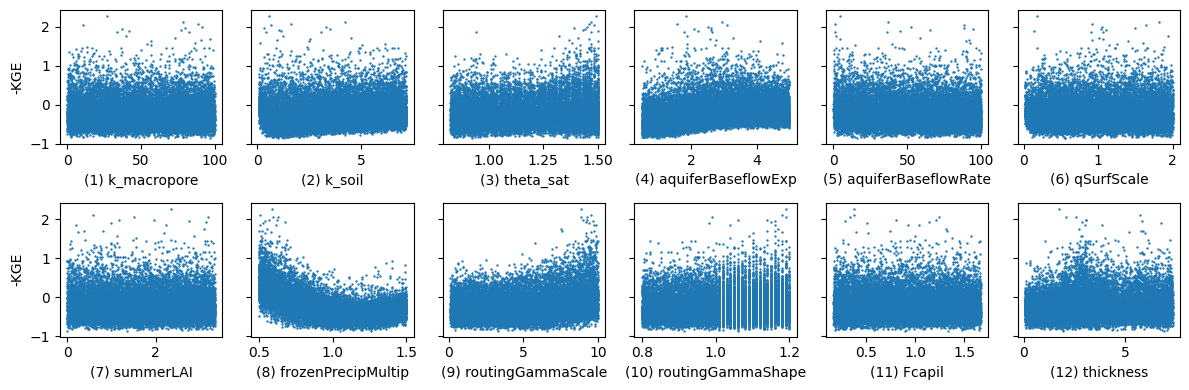

In [17]:
fig, axs = plt.subplots(2, 6, figsize=(12, 4), sharey=True)
for i in range(2): 
    for j in range(6):
        iVar = i*6+j
        axs[i, j].scatter(data[:, 1+iVar], data[:, -1], s=0.5)        
        axs[i, j].set_xlabel('(%d) %s'%(iVar+1, variable_names[iVar]))
        if j==0:
            axs[i, j].set_ylabel('-KGE')
plt.tight_layout()
plt.show()

#### 3. Calculate the first-order sensitivity index
The first-order sensitivity index indicates the sensitivity of the model output (e.g., -KGE) to a model parameter while keeping all other parameters fixed. It represents the direct influence of each individual model parameter on the model output. <br>

Input argument explanations for the **vs.viscous** function are detailed below. For further information, please refer to the source code of pyviscous.  
- **x**: array, shape (n_samples, n_xvariables). Input values in the input space. 
- **y**: array, shape (n_samples, 1). Output values in the output space. 
- **xIndex**: int. The index of the evaluated input variable, starting from zero. 
- **sensType**: str. Type of sensitivity index calculation. Options: 'first', 'total'.
- **n_components**: {int, 'optimal'}, optional, default: 'optimal'. The number of components used in GMCM inference. 
- **MSC**: str, optional, default: 'AIC'. Model selection criteria. Options: 'AIC', 'BIC'.
- **verbose**: bool, optional, default: False. Display detailed processing information on your screen.

In [7]:
# Load input-output data
data = np.loadtxt(sampleFile, skiprows=1, delimiter='\t')
x    = data[:,1:-1]
y    = data[:,-1].reshape(-1,1)    

# Loop xIndex to calculate each input variable's first-order sensitivity indices.
ofile = os.path.join(outputDir,'sens_first.txt')
f = open(ofile, 'w') 
f.write("ID\tValue\n")
    
for xIndex in [7]:
# for xIndex in range(nVar): 
    # calculate sensitivity index
    sens_indx_first, gmcm_first = vs.viscous(x, y, xIndex, sensType='first', n_components='optimal', MSC='AIC', verbose=False)  
    # write result 
    f.write(f"{xIndex + 1}\t{sens_indx_first}\n")  
f.close()

Calculating first-order sensitivity index for variable index 7...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  4
    Sensitivity index = 0.433713


#### 4. Calculate the total-order sensitivity index
The total-order sensitivity index indicates the sensitivity of the model output (e.g., -KGE) to a model parameter, accounting for both direct and interation effects with other parameters. It reflects the overall importance of a model parameter, considering its direct impact as well as its influence through interactions with other parameters. <br>

Input argument explanations for the **vs.viscous** function are consistent with those provided above.

In [6]:
# Load input-output data
data = np.loadtxt(sampleFile, skiprows=1, delimiter='\t')
x    = data[:,1:-1]
y    = data[:,-1].reshape(-1,1)    

# Loop xIndex to calculate each input variable's total-order sensitivity indices.
ofile = os.path.join(outputDir,'sens_total.txt')
f = open(ofile, 'w') 
f.write("ID\tValue\n")
    
for xIndex in [7]:
# for xIndex in range(nVar):     
    # calculate sensitivity index
    sens_indx_total, gmcm_first = vs.viscous(x, y, xIndex, sensType='total', n_components='optimal', verbose=False)     
    # write result 
    f.write(f"{xIndex + 1}\t{sens_indx_total}\n")   
f.close()

Calculating total-order sensitivity index for variable index 7...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  7
    Sensitivity index = 0.671051


#### 5. Visualize the first- and total-order sensitivity indices
The obtained sensitivity results align well with those reported by [Gharari et al. (2020)](https://doi.org/10.5194/hess-24-5953-2020) and [Sheikholeslami et al. (2021)](https://doi.org/10.1029/2020WR028435), proving the consistency and reliability of our findings.

In [5]:
# Load sensitivity results
# specify sensitivity result files
first_order_file = os.path.join(outputDir,'sens_first.txt')
total_order_file = os.path.join(outputDir,'sens_total.txt')

# load sensitivity results
first_order_indices = np.loadtxt(first_order_file, skiprows=1, usecols=[1], delimiter='\t')
total_order_indices = np.loadtxt(total_order_file, skiprows=1, usecols=[1], delimiter='\t')

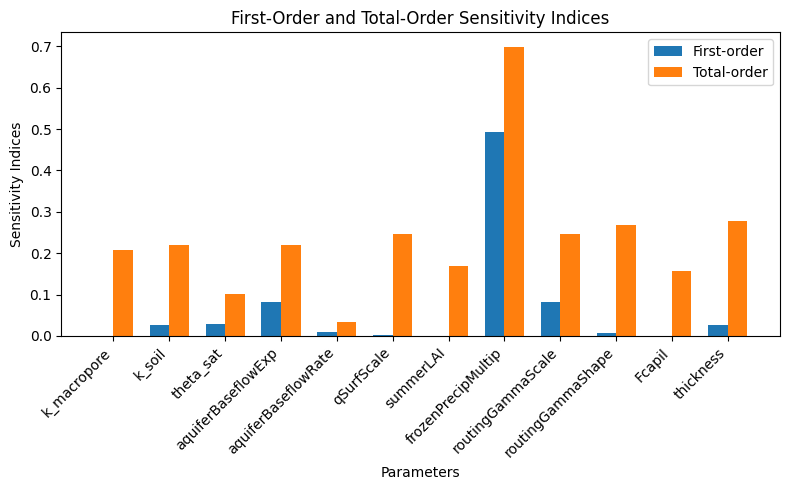

In [11]:
# Plotting sensitivity results
bar_width = 0.35
index = range(len(variable_names))

fig, ax = plt.subplots(figsize=(8, 5))
bar1 = ax.bar(index, first_order_indices, bar_width, label='First-order')
bar2 = ax.bar([i + bar_width for i in index], total_order_indices, bar_width, label='Total-order')

# Adding labels, title, and legend
ax.set_xlabel('Parameters')
ax.set_ylabel('Sensitivity Indices')
ax.set_title('First-Order and Total-Order Sensitivity Indices')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(variable_names, rotation=45, ha='right')
ax.legend()
plt.tight_layout()

# Display the plot
plt.show()
fig.savefig(os.path.join(outputDir,'sens_plot.png'))